In [ ]:
## 提取HFQRS,画图用,150-250HZ 巴特沃斯滤波

In [2]:
import wfdb
from scipy import signal
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import csv
from hrvanalysis import get_time_domain_features
import seaborn as sns

In [3]:
# Loading The Real Data (PTBDB)
with open('D:/paper_data/datasets/ptb-diagnostic-ecg-database-1.0.0/RECORDS') as fp:  
    lines = fp.readlines()

files_unhealthy, files_healthy, files_Heartfailure= [], [], []

for file in lines:
    file_path = "D:/paper_data/datasets/ptb-diagnostic-ecg-database-1.0.0/" + file[:-1] + ".hea"
    
    # Reading The Header To Determine The Class
    if 'Myocardial infarction' in open(file_path).read():
        files_unhealthy.append(file)
        
    if 'Healthy control' in open(file_path).read():
        files_healthy.append(file)

In [4]:
def load_data(file,channel):
    data, _ = wfdb.rdsamp("D:/paper_data/datasets/ptb-diagnostic-ecg-database-1.0.0/" + file[:-1], channel_names=[str(channel)])   
    data = data[:20000]   
    return data.flatten()

In [5]:
## 变量定义
seed_num = 49
#torch.manual_seed(seed_num)
run_num = 7
channel = 'v5'
channels = [channel]
lowcut = 100
highcut = 499
fs = 1000
order = 5
sampling_rate=1000

In [6]:
healthy = []
for file in files_healthy:
    data_healthy = []
    for channel in channels:      
        data = load_data(file,channel)
        data_healthy.append(data)
    healthy.append(data_healthy)
        
unhealthy = []
for file in files_unhealthy:
    data_unhealthy = []
    for channel in channels:      
        data = load_data(file,channel)
        data_unhealthy.append(data)
    unhealthy.append(data_unhealthy)

In [7]:
healthy_np = np.array(healthy)
unhealthy_np = np.array(unhealthy)
X = np.concatenate((healthy_np, unhealthy_np), axis=0)

In [8]:
X.shape

(448, 1, 20000)

In [9]:
def get_qrs(data, sampling_rate):
    qrs = []
    epochs = nk.ecg_segment(data, rpeaks=None, sampling_rate=sampling_rate, show=False)
    for i in range(1, len(epochs) + 1):
        qrs.append(epochs[str(i)].Signal)
    return qrs

In [10]:
from scipy.signal import butter, filtfilt,find_peaks,hilbert
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
import pywt
def butter_bandpass_filter(signal, fs, lowcut, highcut, order):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

## 获取HF_AX

In [11]:
qrs_indexs = []
for ecg in X:
    qrs_index_list = []
    for channel in ecg:
        qrs = get_qrs(channel, 1000)
        qrs_index_list.append(qrs)
    qrs_indexs.append(qrs_index_list)

D:\software\anaconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
D:\software\anaconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


In [12]:
h_qrs_list_ch = qrs_indexs[:80]
unh_qrs_list_ch = qrs_indexs[80:]

In [13]:
h_qrs_list = [person_data for person_data in h_qrs_list_ch if all(len(channel) >= 10 for channel in person_data)]
unh_qrs_list = [person_data for person_data in unh_qrs_list_ch if all(len(channel) >= 10 for channel in person_data)]

In [14]:
h_qrs_list1 = []

# 遍历每个人的数据
for channels in h_qrs_list:
    h_qrs_list1_ch = []  # 为每个人初始化列表
    
    # 遍历每个通道的数据
    for channel in channels:
        channel_subset = channel[:10]  # 从每个通道中取前10个元素
        h_qrs_list1_ch.append(channel_subset)  # 将子集追加到列表中
    
    h_qrs_list1.append(h_qrs_list1_ch)  # 将每个人的列表追加到主列表中
            
        
unh_qrs_list1 = []

# 遍历每个人的数据
for channels in unh_qrs_list:
    unh_qrs_list1_ch = []  # 为每个人初始化列表
    
    # 遍历每个通道的数据
    for channel in channels:
        channel_subset = channel[:10]  # 从每个通道中取前10个元素
        unh_qrs_list1_ch.append(channel_subset)  # 将子集追加到列表中
    
    unh_qrs_list1.append(unh_qrs_list1_ch)  # 将每个人的列表追加到主列表中

In [15]:
qrs_list = h_qrs_list1 + unh_qrs_list1

In [16]:
HF_AX = []
for index in range(len(qrs_list)):  
    if index%100 == 0:
        print("index: ",index)
    HF_ax = []
    for channel in range(len(channels)):
        HF_ax_c = []    
        for i in range(len(qrs_list[index][channel])):
#             hfqrs = ex_amplitude_envelope(qrs_list_ch[index][channel][i], lowcut=100, fs=1000 ,order=8)
            hfqrs= butter_bandpass_filter(qrs_list[index][channel][i], 1000, 150, 250, 5)
            HF_ax_c.append(hfqrs)
        HF_ax.append(HF_ax_c)
    HF_AX.append(HF_ax)

index:  0
index:  100
index:  200
index:  300
index:  400


In [17]:
 len(HF_AX[2][0])

10

In [18]:
import pickle

# 假设 HF_AX 是你的列表
# 保存 HF_AX 到文件
with open('HF_AX_1.pkl', 'wb') as file:
    pickle.dump(HF_AX, file)

## 心电滤波图

In [19]:
import matplotlib.colors as mcolors

In [21]:
X[5][0]

array([0.2065, 0.2045, 0.204 , ..., 0.136 , 0.137 , 0.137 ])

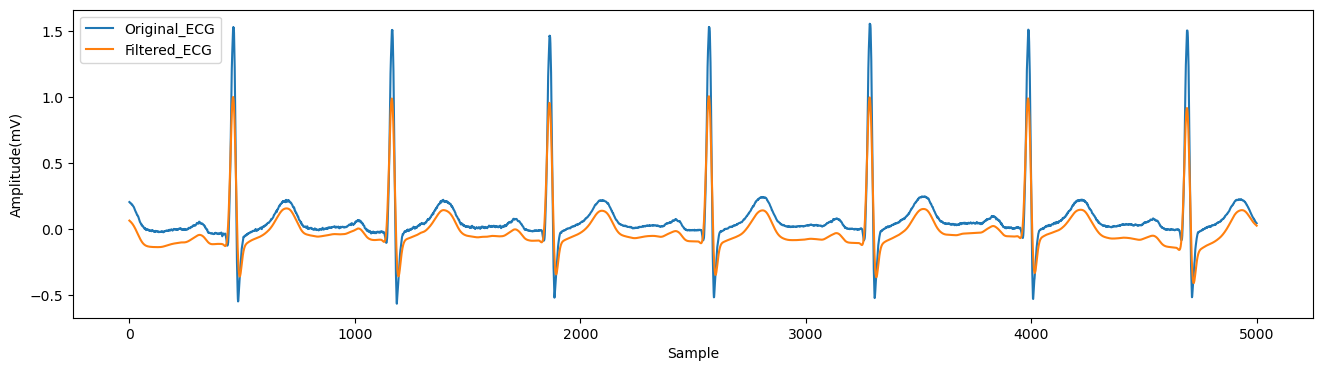

In [39]:
plt.figure(figsize=(16, 4))
cleaned_qrs = nk.ecg_clean(X[5][0][:5000], sampling_rate=1000, method="neurokit")
plt.plot(X[5][0][:5000],label='Original_ECG')
plt.legend()
plt.plot(cleaned_qrs,label='Filtered_ECG')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Amplitude(mV)')
plt.savefig('Filtered_ECG.jpg', dpi=600)  # 保存为PNG格式，分辨率为300dpi
plt.show()

## HF提取

In [29]:
qrs1 = get_qrs(X[5][0][:5000],1000)

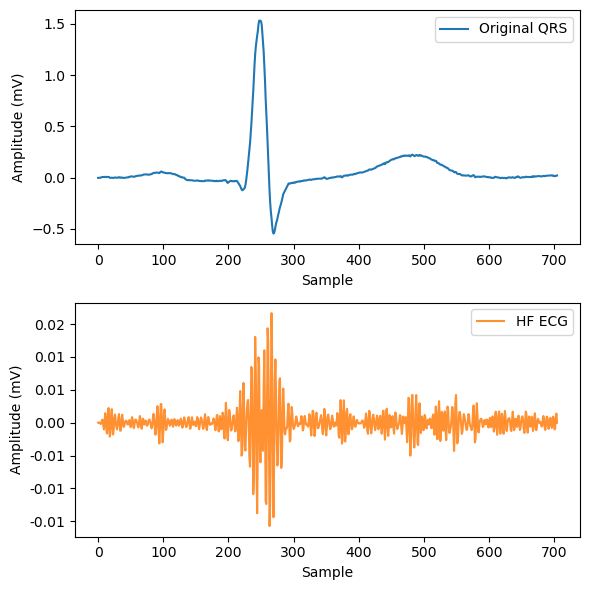

In [40]:
plt.figure(figsize=(6, 6))
# 原始 QRS
plt.subplot(2, 1, 1)
plt.plot(np.arange(705), qrs1[0], label='Original QRS')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()

# 高通滤波后的 ECG
plt.subplot(2, 1, 2)
plt.plot(hfqrs1, label='HF ECG', color='#ff9132')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()

# 设置 y 轴保留两位小数
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))


plt.savefig('HFQRS.jpg', dpi=600)  # 保存为PNG格式，分辨率为300dpi
# 显示图形
plt.tight_layout()
plt.show()

## 健康与心肌梗塞患者对比

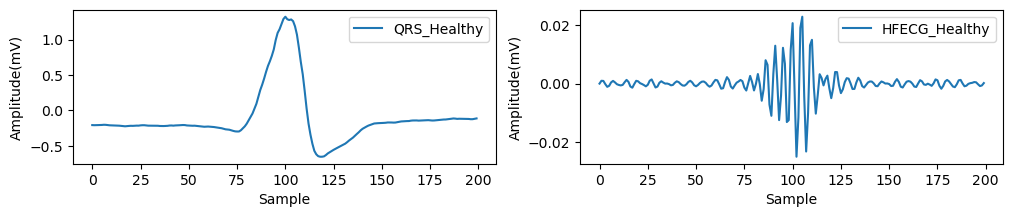

In [42]:
qrs_h = get_qrs(X[20][0][:5000],1000)
qrs_mi = get_qrs(X[113][0][:5000],1000)

plt.figure(figsize=(12, 2))
plt.subplot(1,2,1)
plt.plot(np.arange(200), qrs_h[0][-0.1:0.1],label='QRS_Healthy')
plt.xlabel('Sample')
plt.ylabel('Amplitude(mV)')
plt.legend()


hfqrs_h = butter_bandpass_filter(qrs_h[0][-0.1:0.1], 1000, 150, 250, 5)
plt.subplot(1,2,2)
plt.plot(hfqrs_h,label='HFECG_Healthy')
plt.xlabel('Sample')
plt.ylabel('Amplitude(mV)')
plt.legend()
                
# plt.figure(figsize=(12, 4))
# plt.subplot(2,2,3)
# plt.plot(np.arange(200),qrs_mi[0][-0.1:0.1],label='QRS_MI',color='#ff9132')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude(mV)')
# plt.legend()


# hfqrs_mi = butter_bandpass_filter(qrs_mi[0][-0.1:0.1], 1000, 150, 250, 5)
# plt.subplot(2,2,4)
# plt.plot(hfqrs_mi,label='HFECG_MI',color='#ff9132')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude(mV)')
# plt.legend()
plt.savefig('heaQRS.jpg', dpi=600)  # 保存为PNG格式，分辨率为300dpi
plt.show()